#### `Unconstrained` optimization for differentiable convex function

For differentiable `convex` function $f: \mathbf{R}^n \rightarrow \mathbf{R}$, we want to

$$\min f(x)$$

$x^*$ is an optimal solution to this problem if

$$\boxed{\nabla f(x^*)=0}$$

This can be seen from 1st order condition for convexity of $f$

$$f(x)\geq f(x^*) + \nabla f(x^*)^T(x-x^*)$$

When $\nabla f(x^*)=0$, we have $$f(x)\geq f(x^*)$$

which means $f(x^*)$ is optimal value

#### General `descent` method

$$x^{k+1} = x^k+t^k\Delta x^k$$

with $f(x^{k+1})<f(x^k)$

* $\Delta x^k$: search `direction`
* $t^k$: `step size`, learning rate, etc.

Other notation $x^+=x+t\Delta x, \,x^{k+1}=x^k+t d^k$ and many others

##### Requirement for search direction

By convexity of $f$ and 1st order condition, we have (let $t^k=1$ for simplicity)

$$\begin{align*}
f(x^{k+1})-f(x^k)&\geq \nabla f(x^k)^T (x^{k+1}-x^k)=\nabla f(x^k)^T\Delta x^k \\
\end{align*}$$

We also want our algorithm to satisfy

$$f(x^{k+1})-f(x^{k})<0$$

Combine these two and we have the `requirement for search direction`

$$ \boxed{\nabla f(x^k)^T\Delta x^k\leq f(x^{k+1})-f(x^k)<0}$$

That is, its `inner product with gradient` must be `negative`

Once the search direction is determined, we need to decide `step size` through line search

##### Line search for step size

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, Ellipse, Circle
import time

np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
plt.style.use('dark_background')

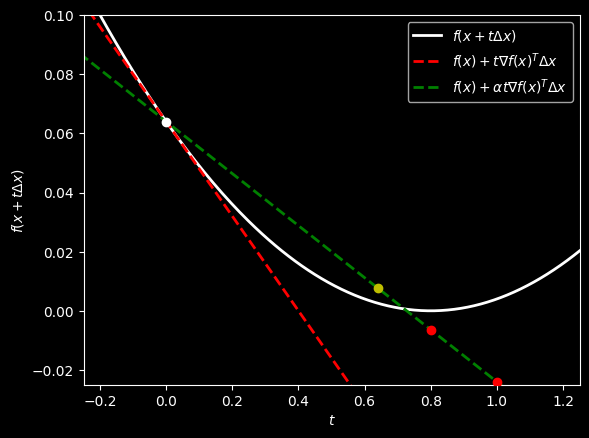

In [17]:
def f(t):
    return 0.1 * (t-0.8) ** 2

def grad_f(t):
    return 0.2 * (t-0.8)

def lower_bound(x, t):
    return f(x) + t * grad_f(x)

def line_search(x, t, alpha):
    return f(x) + alpha * t * grad_f(x)

x = 0.
alpha = 0.55
beta= 0.8

t = np.linspace(-0.5, 1.5, 300)

plt.plot(t, f(t), label="$f(x+t\Delta x)$", color='w', linewidth=2)
plt.plot(t, lower_bound(x,t), label=r"$f(x)+t\nabla f(x)^T \Delta x$", color='r', ls='--', linewidth=2)
plt.plot(t, line_search(x,t, alpha), label=r"$f(x)+\alpha t\nabla f(x)^T \Delta x$", color='g', ls='--',linewidth=2)

plt.scatter(x, f(x), color='w', zorder=5)
plt.scatter(1, line_search(x, 1, alpha), color='r', zorder=5)
plt.scatter(0.8, line_search(x, 0.8, alpha), color='r', zorder=5)
plt.scatter(0.64, line_search(x, 0.64, alpha), color='y', zorder=5)

plt.xlabel("$t$")
plt.ylabel("$f(x+t\Delta x)$")
plt.ylim(-0.025, 0.1)
plt.xlim(-0.25, 1.25)
plt.legend()
plt.show()

Line search reduces the problem to a 1D function of $t$ ($x$ and $\Delta x$ are fixed for this iteration) so we can plot it as shown above (iteration index $k$ is omitted for clarity)

The ideal case would be solving the following `exact line search` problem

$$t= \arg \min_{t>0} f(x+t\Delta x)$$

However, `empirical` approach often works just as well, for example `backtracking line search`

The idea is to first choose parameters $\alpha$ and $\beta$, commonly in $(0, 1)$ and do the following

* Starting at $t=1$, repeat $t=\beta t$ until

$$f(x+t\Delta x)<f(x)+\alpha t \nabla f(x)^T\Delta x$$

Based on 1st order condition for convex function, this inequality would `never` hold if $\alpha=1$. This is because the right hand side would be just $f(x)+t \nabla f(x)^T\Delta x$, which is a `lower bound` (red line) of $f(x+t\Delta x)$

So, the only way that the inequality hold is to

* lower the slope (green line) by parameter $\alpha$
* reduce $t$ with parameter $\beta$
(or think it the other way, as $\nabla f(x)^T\Delta x<0$, reducing $\alpha$ or $t$ makes right hand side $f(x)+\alpha t \nabla f(x)^T\Delta x$ larger by substracting a smaller value)

For example, in the figure, we start with step size $t=1$ and see that after two iterations and we get to $t=0.8\times0.8 =0.64$, the following holds

$$f(x+t\Delta x)<f(x)+\alpha t \nabla f(x)^T\Delta x$$

and we choose `step size` $t=0.64$ for this iteration of descent

#### `Gradient descent` and 1st order approximation

Iteratively minimize 1st order Taylor approximation of $f: \mathbf{R}^n \rightarrow \mathbf{R}$

$$f(x)\approx f(x_0)+\nabla f(x_0)^T(x-x_0)$$

The idea is to minimize $f(x)$ while not moving too far away from $x_0$

Therefore, we have the `objective function` at iteration $k$ as

$$x^{k+1}=\arg \min_xf(x^{k})+\nabla f(x^{k})^T(x-x^{k})+\frac{1}{2t^k}\|x-x^{k}\|_2^2$$

We take derivative of the objective function and set it to zero

$$0+\nabla f(x^{k})+\frac{1}{t^k}(x-x^{k})=0$$

and we get the gradient descent equation

$$x^{k+1}=x^{k}-t^k \nabla f(x^{k})$$

which
* uses search direction $\boxed{\Delta x^k = -\nabla f(x^k)}$
* finds step size $t^k$ through line search

#### Line search comparison example

In [18]:
def f(x, A):
    return 0.5 * x @ A @ x

def grad_descent(A, x_0, exact_line_search=True, emp_t=None, tol=1e-6):
    x = x_0
    x_list = [x]
    alpha = 0.01
    beta = 0.5
    while True:
        delta_x = - A @ x
        if emp_t is None:
            if exact_line_search:
                # analytical solution for exact line search
                A2 = A @ A
                A3 = A2 @ A
                t = (x.T @ A2 @ x) / (x.T @ A3 @ x)
            else:
                # do t = t * beta
                # until f(x+t Delta_x)<f(x)+alpha t nabla f(x)^T Delta_x
                t = 1
                while f(x + t * delta_x, A) > f(x, A) + alpha * t * ((A @ x) @ delta_x):
                    t *= beta
        else:
            t = emp_t
        x = x + t * delta_x
        if np.linalg.norm(x - x_list[-1]) < tol:
            break
        x_list.append(x.copy())

    return np.array(x_list)

In [19]:
A = np.array([[5, 2],[2, 3]])
x_0 = np.array([-3, -14])
tol = 1e-6

traj_opt = grad_descent(A, x_0=x_0, exact_line_search=True, emp_t=None, tol=tol)
traj_bls = grad_descent(A, x_0=x_0, exact_line_search=False, emp_t=None, tol=tol)
traj_emp = grad_descent(A, x_0=x_0, exact_line_search=False, emp_t=0.1, tol=tol)
print("Steps to converge (exact line search):", len(traj_opt)-1)
print("Steps to converge (backtrack line search):", len(traj_bls)-1)
print("Steps to converge (empirical step size):", len(traj_emp)-1)

Steps to converge (exact line search): 16
Steps to converge (backtrack line search): 29
Steps to converge (empirical step size): 75


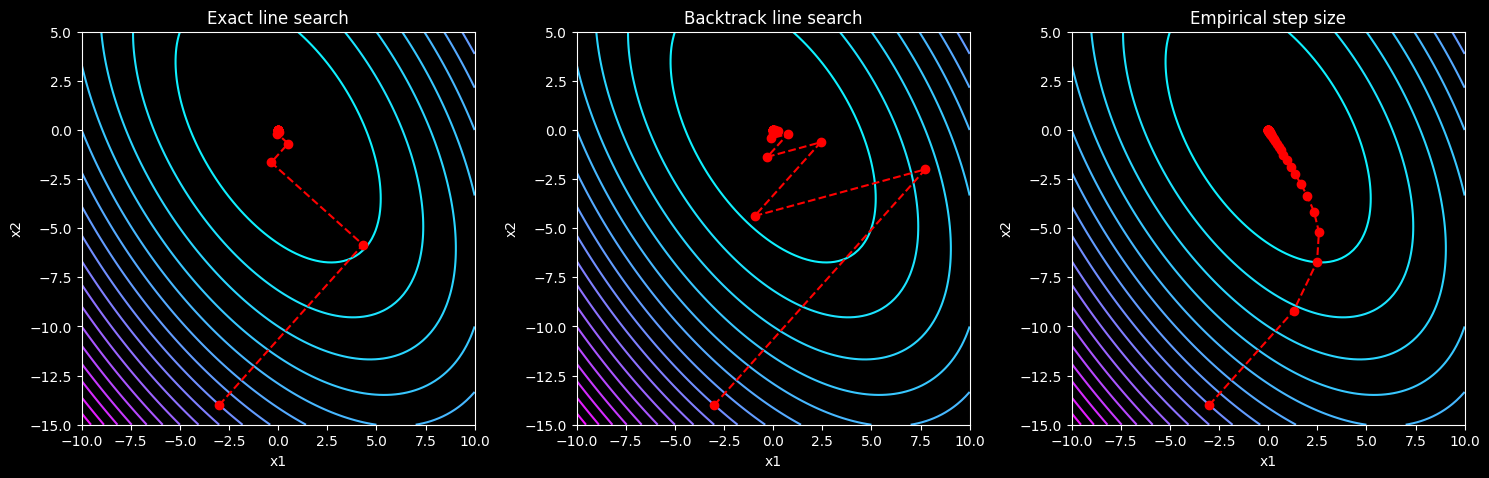

In [20]:
x_vals = np.linspace(-10, 10, 100)
y_vals = np.linspace(-15, 5, 100)
X, Y = np.meshgrid(x_vals, y_vals)
fx = np.vectorize(lambda x, y: f(np.array([x, y]), A))
Z = fx(X, Y)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].contour(X, Y, Z, levels=20, cmap='cool')
axes[0].plot(traj_opt[:, 0], traj_opt[:, 1], 'o--', color='red')
axes[0].set_title("Exact line search")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].set_aspect('equal')

axes[1].contour(X, Y, Z, levels=20, cmap='cool')
axes[1].plot(traj_bls[:, 0], traj_bls[:, 1], 'o--', color='red')
axes[1].set_title("Backtrack line search")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")
axes[1].set_aspect('equal')

axes[2].contour(X, Y, Z, levels=20, cmap='cool')
axes[2].plot(traj_emp[:, 0], traj_emp[:, 1], 'o--', color='red')
axes[2].set_title("Empirical step size")
axes[2].set_xlabel("x1")
axes[2].set_ylabel("x2")
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

#### Gradient descent with `ill-conditioned` problem

Consider 100-smooth and 1-strongly convext function

$$f(x)=\frac{1}{2}x^T Q x, Q=\begin{bmatrix}100& 0 \\ 0 & 1\end{bmatrix}\, \rightarrow \kappa=100$$

Since the `Hessian` $\nabla^2f(x)$ is just $Q$, we can verify the smoothness and strong convexity parameter by the largest and smallest eigenvalues of $Q$

$$\lambda_{\max}(Q)\leq100 \Longleftrightarrow Q\leq 100I $$

therefore, $Q$ is 100-smooth

Similarly

$$\lambda_{\min}(Q)\geq 1 \Longleftrightarrow Q\geq I$$

therefore, $Q$ is 1-strongly convex

The function's sublevel sets are `ellipsoids` that are very thin along $x_1$ and very extended along $x_2$

The mininum value is at $\begin{bmatrix}0 \\ 0\end{bmatrix}$

For this problem, assume we have initial guess at $x^0=\begin{bmatrix}0.01 \\ 1\end{bmatrix}$ and we work out our `search direction ` for gradient descent

$$\Delta x^0=-\nabla f(x)|_{x=x^0}=-Qx^0=-\begin{bmatrix}1 \\ 1\end{bmatrix}$$

Immediately, we see the negative gradient direction is not even remotely pointing to the origin...

We then use exact line search to work out `step size`

$$\begin{align*}t^0 &= \arg \min_{t>0} f(x^0+t\Delta x^0)\\
&= \arg \min_{t>0} \frac{1}{2}\begin{bmatrix}0.01-t \\ 1-t\end{bmatrix}^T\begin{bmatrix}100& 0 \\ 0 & 1\end{bmatrix}\begin{bmatrix}0.01-t \\ 1-t\end{bmatrix}\\
&=\arg \min_{t>0} \frac{1}{2}\left(100(0.01-t)^2+(1-t)^2\right)
\end{align*}$$

Take derivative and set to zero, we have

$$200(t-0.01)+2(t-1)=0 \Rightarrow t^0=\frac{2}{101}$$

Plug into gradient descent

$$\begin{align*}
x^1&=x^0-\frac{2}{101}Qx^0 \\
&=x^0\left(I-\frac{2}{101}Q\right) \\
&=\begin{bmatrix}0.01\cdot\frac{-99}{101} \\ 1\cdot\frac{99}{101}\end{bmatrix} \\
&\approx \begin{bmatrix}-0.01 \\ 0.98\end{bmatrix}
\end{align*}$$

We see that $x^1$ barely moves closer to mininum, and it overshoots in $x_1$ direction

#### `Convergence analysis` for smooth and strongly convex functions

We can also assess `general` convergence behavior of gradient descent with smooth and strongly convex functions

Recall `co-coercivity` of $M$-`smooth` and `convex` function

$$\langle \nabla f(x) - \nabla f(y), x-y \rangle \geq \frac{1}{M}\|\nabla f(x)-\nabla f(y)\|_2^2$$

Let $f$ also be $m$-`strongly convex`, by definition, the following function is `convex`

$$f(x)-\frac{m}{2}\|x\|_2^2$$

In addition

$$\frac{M-m}{2}\|x\|_2^2-\left(f(x)-\frac{m}{2}\|x\|_2^2\right)=\frac{M}{2}\|x\|_2^2-f(x)$$

which is `convex` due to $M$-`smoothness` of $f$

Therefore, by definition

$$f(x)-\frac{m}{2}\|x\|_2^2$$

is also a $(M-m)$-`smooth function`

We apply co-coercivity to $f(x)-\frac{m}{2}\|x\|_2^2$ to get

$$\langle \nabla f(x) - \nabla f(y) - m(x-y), x-y \rangle \geq \frac{1}{M-m}\|\nabla f(x)-\nabla f(y)- m(x-y)\|_2^2$$

Split and rearrange...

$$\begin{align*}&\langle \nabla f(x) - \nabla f(y) - m(x-y), x-y \rangle \\
& =\langle \nabla f(x) - \nabla f(y) , x-y \rangle - \langle m(x-y) , x-y \rangle \\
&= \langle \nabla f(x) - \nabla f(y) , x-y \rangle - m \| x-y \|_2^2 \\
& \text{now right hand side...} \\
& \geq \frac{1}{M-m}\|\nabla f(x)-\nabla f(y)\|_2^2 +\frac{m^2}{M-m} \|x-y\|_2^2 -\frac{2m}{M-m}  \langle \nabla f(x) - \nabla f(y) , x-y \rangle
\end{align*}$$

Rearrange...

$$\langle \nabla f(x) - \nabla f(y), x-y \rangle +\frac{2m}{M-m}\langle \nabla f(x) - \nabla f(y), x-y \rangle\\
\geq m\|x-y\|_2^2+\frac{1}{M-m}\|\nabla f(x) - \nabla f(y)\|_2^2+\frac{m^2}{M-m}\|x-y\|_2^2$$

Simplify...

$$\frac{M+m}{M-m}\langle \nabla f(x) - \nabla f(y), x-y \rangle\geq \frac{Mm}{M-m}\|x-y\|_2^2+\frac{1}{M-m}\|\nabla f(x) - \nabla f(y)\|_2^2$$

or

$$\langle \nabla f(x) - \nabla f(y), x-y \rangle\geq \frac{mM}{m+M}\|x-y\|_2^2+\frac{1}{m+M}\| \nabla f(x) - \nabla f(y)\|_2^2$$

which looks like `coercivity` (bounded by difference in variable values) combined with `co-coercivity` (bounded by difference in gradients)

For gradient descent, if we choose `step size` $t=\frac{2}{m+M}$ (in the example above, we have $t=\frac{2}{m+M}=\frac{2}{101}$)

$$x^{k+1}=x^k-t\nabla f(x^k)$$

and

$$\begin{align*}
\|x^{k+1}-x^*\|_2^2&=\|x^k-t\nabla f(x^k)-x^*\|_2^2 \\
&=\|x^k-x^*\|_2^2-2t\langle \nabla f(x^k), x^k-x^*\rangle +t^2\|\nabla f(x^k)\|_2^2 \\
& \nabla f(x^*)=0 \\
&=\|x^k-x^*\|_2^2-2t\langle \nabla f(x^k)-\nabla f(x^*), x^k-x^*\rangle +t^2\|\nabla f(x^k)\|_2^2 \\
&\langle \nabla f(x) - \nabla f(y), x-y \rangle\geq \frac{mM}{m+M}\|x-y\|_2^2+\frac{1}{m+M}\| \nabla f(x) - \nabla f(y)\|_2^2 \\
&\leq \left(1-2t\frac{mM}{m+M}\right)\|x^k-x^*\|_2^2 + \left(t^2-2t\frac{1}{m+M}\right)\|\nabla f(x^k)\|_2^2 \\
& t = \frac{2}{m+M} \Rightarrow t^2-2t\frac{1}{m+M}= 0 \\
&= \left(1-2t\frac{mM}{m+M}\right)\|x^k-x^*\|_2^2 \\
&= \left(1-\frac{4mM}{(m+M)^2}\right)\|x^k-x^*\|_2^2 \\
&= \frac{(m-M)^2}{(m+M)^2}\|x^k-x^*\|_2^2 \\
&= \left(\frac{M/m-1}{M/m+1}\right)^2\|x^k-x^*\|_2^2\\
&= \boxed{\left(\frac{\kappa-1}{\kappa+1}\right)^2\|x^k-x^*\|_2^2}\\
\end{align*}$$

This is sort of where the number $\frac{99}{101}$ in the example comes from

We can imagine that as $\kappa$ gets moderately large, gradient descent becomes so slow that it is much less useful...

#### `Steepest descent` method

Recall that for gradient descent, if we set step size $t^k=1$, we can find the optimal `search direction` $\Delta x$ by solving a regularized minimization of 1st Taylor approximation of the function at $x^k$

$$\begin{align*}\Delta x^k&=\arg \min_{v}f(x^{k})+\nabla f(x^{k})^Tv+\frac{1}{2}\|v\|_2^2 \\
&=\arg \min_{v} \nabla f(x^{k})^Tv+\frac{1}{2}\|v\|_2^2 \\
& = -\nabla f(x^k)
\end{align*}$$

Here, the term $\frac{1}{2}\|v\|_2^2$ constrains the solution to be `not too far away` from $x^k$, as measured by the $l_2$ norm

##### Search direction under `arbitrary norm`

But what if $v$ is measured by some `arbitrary norm`?

The solution is known as the (unnormalized) steepest descent, or `sd` direction

$$\boxed{\Delta x_{sd}=\arg \min_v \nabla f(x)^Tv+\frac{1}{2}\|v\|^2 }$$

Let $v=sw$, where

* $s>0$ is the scaling factor
* $w$ is a unit vector measured by this arbitrary norm, $\|w\|=1$, representing the search direction

We first minimize over $s$ with the objective

$$s\nabla f(x)^T w+\frac{s^2}{2}$$

We take the derivative and set to zero

$$\nabla f(x)^Tw+s=0 \Rightarrow s=-\nabla f(x)^Tw$$

Plug $s$ back to the objective, we have

$$-(\nabla f(x)^Tw)^2 +\frac{1}{2}(\nabla f(x)^Tw)^2=-\frac{1}{2}(\nabla f(x)^Tw)^2$$

and minimizing over $w$ is equivalent to

$$\begin{align*}w&=\arg \min_{\|w\|=1} -\frac{1}{2}(\nabla f(x)^Tw)^2 \\
&=\arg \max_{\|w\|=1} |\nabla f(x)^Tw|
\end{align*}$$

Recall the definition of `dual norm`

$$\begin{align*}
\|\nabla f(x)\|_* &= \sup_{\|w\|=1} \nabla f(x)^Tw \\
& \text{symmetry of norm} \\
&= \sup_{\|w\|=1} |\nabla f(x)^Tw| \\
\end{align*}$$

Therefore, the solution $w$ satisfies $|\nabla f(x)^Tw|=\|\nabla f(x)\|_*$

`Note`, here we need to use the definition based on absolute value to be consistent with optimization of $w$

Since $s=-\nabla f(x)^Tw>0$, therefore

$$|\nabla f(x)^Tw|=-\nabla f(x)^Tw=\boxed{s=\|\nabla f(x)\|_*}$$

Naturally, we can let this $w$ be the `normalized` steepest descent search direction $\Delta x_{nsd}$, and we have the relationship between $\Delta x_{sd}$ and $\Delta x_{nsd}$

$$\boxed{\Delta x_{sd}=\|\nabla f(x)\|_*\Delta x_{nsd}}$$

##### `Quadratic` norm search direction

For the quadratic norm defined as

$$\|v\|_P=(v^TPv)^{1/2}, P\in S^n_{++}$$

we can write out the steepest descent problem

$$\Delta x_{sd}=\arg \min_v \nabla f(x)^Tv+\frac{1}{2}v^TPv $$

Notice that we can write the quadratic norm as Euclidean norm

$$\begin{align*}\|v\|_P&=(v^TPv)^{1/2}=\|P^{1/2}v\|_2
\end{align*}$$

Therefore, we can transform the problem into what we are familiar with by letting

$$z=P^{1/2}v$$

and we have

$$\Delta z_{sd}=\arg \min_z \nabla f(x)^TP^{-1/2}z+\frac{1}{2}\|z\|_2^2 $$

Take derivative w.r.t. $z$ and set to zero, we have

$$P^{-1/2}\nabla f(x)+z=0 \Rightarrow \Delta z_{sd}=-P^{-1/2}\nabla f(x)$$

Convert back

$$\begin{align*}\Delta x_{sd}&=P^{-1/2}\Delta z_{sd} \\
& = \boxed{-P^{-1}\nabla f(x)}
\end{align*}$$

##### `Geometric` interpretation

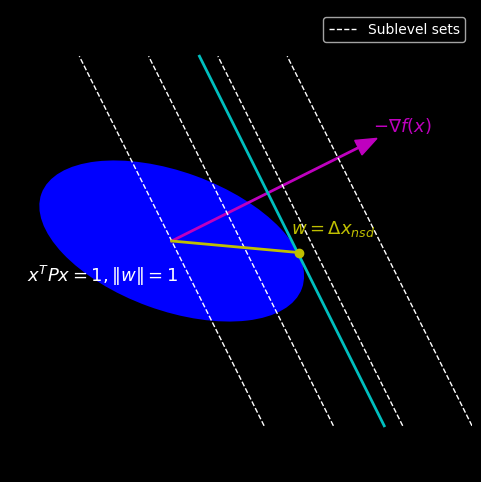

In [21]:
fig_1, ax_1 = plt.subplots(figsize=(6, 6))

ax_1.plot([0, 0.8], [0, 0.4], 'm', linewidth=2)
ax_1.plot([0.4, -0.4], [-0.8, 0.8], 'w--', linewidth=1, label='Sublevel sets')
ax_1.plot([0.7, -0.1], [-0.8, 0.8], 'w--', linewidth=1)
ax_1.plot([1.0, 0.2], [-0.8, 0.8], 'w--', linewidth=1)
ax_1.plot([0.92, 0.12], [-0.8, 0.8], 'c', linewidth=2)
ax_1.plot([1.3, 0.5], [-0.8, 0.8], 'w--', linewidth=1)
ax_1.scatter(0.55, -0.05, zorder=10, color='y')
ax_1.arrow(0.8, 0.4, 0.008, 0.004,  head_width=0.07, head_length=0.09, fc='m', ec='m')
ax_1.plot([0, 0.55], [0, -0.05], 'y', linewidth=2)
ax_1.text(-0.3, -0.15, r'$x^TPx= 1, \|w\|=1$', horizontalalignment='center', verticalalignment='center', fontsize=13, color='w')
ax_1.text(1, 0.5, r'$-\nabla f(x)$', horizontalalignment='center', verticalalignment='center', fontsize=13, color='m')
ax_1.text(0.7, 0.05, r'$w=\Delta x_{nsd}$', horizontalalignment='center', verticalalignment='center', fontsize=13, color='y')

ellipsoid = Ellipse((0,0), 0.6, 1.2, angle=70, edgecolor='none', facecolor='blue', zorder=-5)
ax_1.add_patch(ellipsoid)
ax_1.set_aspect('equal')
ax_1.set_xlim(-0.7,1.3)
ax_1.set_ylim(-1,1)
ax_1.legend()
ax_1.axis('off')

plt.show()

From the expression, we see that the direction of gradient descent is transformed by $P^{-1}$

To see where the direction is `after transformation`, we can write eigendecomposition of $P^{-1}$ as

$$P=Q\Lambda Q^T\Rightarrow P^{-1}=Q\Lambda ^{-1}Q^T$$

Therefore, the component of $-\nabla f(x)$ will be stretched by $\lambda_i^{-1}$ in the `direction of the eigenvector` $q_i$ of $P$

To visualize these directions, recall that the semiaxes for the ellipsoid

$$\{x|x^TPx\leq 1\}$$

is given by $\lambda_i^{-1/2}q_i$

As a result, geometrically, we can think of placing $-\nabla f(x)$ at the center of the ellipoid $\{x|x^TPx\leq 1\}$, and stretch it along each semiaxis direction by the amount that equals the `length of semiaxis squared`

More generally, if we look at the optimization to get $w$ or $\Delta x_{nsd}$

$$\begin{align*}w&=\arg \min_{\|w\|=1} -\frac{1}{2}(\nabla f(x)^Tw)^2 \\
&=\arg \max_{\|w\|=1} |\nabla f(x)^Tw| \\
\end{align*}$$

the `sublevel` sets of the objective function in this optimization problem are parallel hyperplanes perpendicular to $\nabla f(x)$, with value increase in both $-\nabla f(x)$ and $\nabla f(x)$ directions. However, since we require $\nabla f(x)^Tw<0$, we only focus on the $-\nabla f(x)$ direction

Now, with the `unit ball` constaint (defined using `quadratic norm` $\|w\|=(w^TPw)^{\frac{1}{2}}$), we can consider finding the normalized search direction $\Delta x_{nsd}$ as gradually moving a hyperplane from far away in the $-\nabla f(x)$ direction towards the unit ball $\|w\|=1$ until the first touch that gives $\Delta x_{nsd}$

#### `Newton step` and 2nd order approximation

If we look at the expression again for steepest descent under quadratic norm

$$\Delta x_{sd}=\arg \min_v \nabla f(x)^Tv+\frac{1}{2}v^TPv $$

we see that it is so similar to the 2nd order Taylor approximation

$$f(x+v)\approx f(x)+\nabla f(x)^Tv+\frac{1}{2}v^T\nabla^2f(x)v$$

We take derivative w.r.t. $v$ and set it to 0, we have the search direction

$$\nabla f(x)+\nabla^2f(x)v=0 \rightarrow \Delta x_{nt}=v=-\left(\nabla^2f(x)\right)^{-1}\nabla f(x)$$

This is known as `Newton step`, corresponding to the steepest descent direction under `quadratic norm induced by local Hessian`

$$\|u\|_{\nabla^2f(x)}=\left(u^T\nabla^2f(x)u\right)^{1/2}$$

#### Gradient descent is `not affine invariant`

Recall our example earlier

$$f(x)=\frac{1}{2}x^T Q x, Q=\begin{bmatrix}100& 0 \\ 0 & 1\end{bmatrix}, \,\kappa=100$$

If we let $A=\begin{bmatrix}0.1& 0 \\ 0 & 1\end{bmatrix}$ and do a `transformation` $x=Ay$, where $A$ is `PD` and `invertible`, and let

$$\begin{align*}
g(y)=f(Ay)&=\frac{1}{2}y^TA^TQAy\\
&=\frac{1}{2}y^TIy
\end{align*}$$

We see that $g$ is a function of $y$ with $\kappa=1$

Apparently, minimizing $g(y)$ and minimizing $f(x)$ should be `equivalent` in terms of the optimal value (of the function)

We can compute the gradient descent `search direction` at $y^0$ as

$$\Delta y^0=-\nabla g(y^0)=-y^0$$

Then, we use exact line search to determine the `step size`

$$\begin{align*}
t&=\arg \min_{t>0}g(y+t\Delta y) \\
&=\arg \min_{t>0}\frac{1}{2}(y-ty)^T(y-ty) \\
&=\arg \min_{t>0}\frac{1}{2}\|(y-ty)\|_2^2 \\
&=1
\end{align*}$$

Therefore, with one `single` descent step, gradient descent would converge to the minimum of $g(y)$

$$y^1=y^0-1\cdot y^0=\begin{bmatrix}0 \\ 0\end{bmatrix} \Rightarrow g(y^1)=0$$

This indicates that affine transformation can drastically change the gradient descent convergence behavior

#### Newton step is `affine invariant`

Assuming transformation $A$ is nonsingular, we first write out the following

$$\begin{align*}
g(y)=f(Ay)&=f(x) \\
\nabla g(y)=A^T\nabla f(Ay)&=\boxed{A^T\nabla f(x)}\\
\nabla^2g(y)=A^T\nabla ^2 f(Ay)A&=\boxed{A^T\nabla ^2 f(x)A}
\end{align*}$$

Then, apply Newton step on $g(y)$

$$\begin{align*}
\Delta y_{nt}&= -\nabla^2g(y)^{-1}\nabla g(y) \\
& = -\left(A^T\nabla ^2 f(x)A\right)^{-1}A^T\nabla f(x) \\
& = -A^{-1}\nabla^2f(x)^{-1}A^{-T}A^T\nabla f(x) \\
& = A^{-1}\left(-\nabla^2f(x)^{-1}\nabla f(x)\right) \\
& = A^{-1}\Delta x_{nt}
\end{align*}$$

and we get

$$x^{k+1}=x^{k}+t\Delta x_{nt}=A(y^k+t\Delta y_{nt})=Ay^{k+1}$$

That is, the `descent trajectories` of running `Newton step` on $g(y)$ and on $f(x)$ satisfy

$$y^k=A^{-1}x^k$$

for all $k$

Therefore, Newton step is `invariant to affine transformation`

#### Newton step and `optimal affine transformation` for gradient descent

We see from the section of gradient descent that we want to find the transformation $x=Ay$ such that $g(y)=f(Ay)$ locally has a `condition number of 1`

Local condition number can be expressed using `Hessian` describing the curvature

$$\lambda_{max}\nabla^2g(x)/\lambda_{min}\nabla^2g(x)$$

If the Hessian matrix has a poor condition number, the gradient along the eigenvector with the largest eigenvalue is much smaller than the one with the smallest eigenvalue

We can show that an `optimal` affine transformation would lead to the equivalency between running gradient descent on $g(y)$ and running Newton step on $f(x)$

So what we want is

$$\nabla^2g(y)=A^T\nabla ^2 f(x)A=I$$

If we choose the transformation

$$A=\left(\nabla^2f(x)\right)^{-1/2}$$

We can verify that $\nabla^2g(y)=I$

We now plug this into `gradient descent` on $g(y)$

$$\begin{align*}y^{k+1}&=y^k-t\nabla g(y^k) \\
&=A^{-1}x^k-t A^T\nabla f(x^k) \\
&=A^{-1}x^k-A^{-1}At A^T\nabla f(x^k) \\
& A=\left(\nabla^2f(x)\right)^{-1/2} \\
&=A^{-1}\left(x^k-t \left(\nabla^2f(x^k)\right)^{-1}\nabla f(x^k)\right) \\
&=A^{-1}x^{k+1}
\end{align*}$$

That is, the `descent trajectories` of running `gradient descent` on $g(y)$ and running `Newton step` on $f(x)$ satisfy

$$y^k=A^{-1}x^k$$

for all $k$

Therefore, the optimal affine transformation makes gradient descent on $g(y)$ as `efficient` as Newton step on $f(x)$

#### Newton decrement

Newton decrement $\lambda(x)$ is a measure of the proximity of $f(x)$ to the minimizer $p^*$

$$\begin{align*}
\lambda(x)&=\boxed{\left(\nabla f(x)^T \left(\nabla^2f(x)\right)^{-1}\nabla f(x)\right)^{1/2}} \\
& \nabla^2f(x)=\left(\nabla^2f(x)\right)^T \\
&=\left[\nabla f(x)^T\left(\left(\nabla^2f(x)\right)^{-T} \nabla^2f(x)\right)\left(\left(\nabla^2f(x)\right)^{-1}\nabla f(x)\right)\right]^{1/2}\\
&=\left[\left(\nabla f(x)^T\left(\nabla^2f(x)\right)^{-T}\right) \nabla^2f(x)\left(\left(\nabla^2f(x)\right)^{-1}\nabla f(x)\right)\right]^{1/2} \\
&=\left[\left(\left(\nabla^2f(x)\right)^{-1}\nabla f(x)\right)^T \nabla^2f(x)\left(\left(\nabla^2f(x)\right)^{-1}\nabla f(x)\right)\right]^{1/2} \\
& \Delta x_{nt}=-\left(\nabla^2f(x)\right)^{-1}\nabla f(x)\\
& = \boxed{\left(\Delta x_{nt}^T \nabla^2 f(x) \Delta x_{nt}\right)^{1/2}}
\end{align*}$$

That is, the Newton decrement is the `Newton step measured using quadratic norm` under the Hessian

We can relate Newton decrement to 2nd order approximation of $f$ at $x$

$$\begin{align*}
f(x)-\inf_{u} \hat{f}(x+u) &= f(x)-\hat{f}(x+\Delta x_{nt}) \\
& = f(x) - \left(f(x)+\nabla f(x)^T\Delta x_{nt}+\frac{1}{2}\Delta x_{nt}^T\nabla^2f(x)\Delta x_{nt}\right) \\
& \Delta x_{nt}=-\left(\nabla^2f(x)\right)^{-1}\nabla f(x)\\
& = \nabla f(x)^T\left(\nabla^2f(x)\right)^{-1}\nabla f(x)-\frac{1}{2}\Delta x_{nt}^T\nabla^2f(x)\Delta x_{nt} \\
& = \lambda(x)^2-\frac{1}{2}\lambda(x)^2 \\
&=\boxed{\frac{1}{2}\lambda(x)^2}
\end{align*}$$

Therefore, $\frac{1}{2}\lambda(x)^2$ provides an estimate of $f(x)-p^*$ `based on 2nd order approximation` of $f$ at $x$

#### Newton decrement is `affine invariant`

This is because

$$\begin{align*}
\lambda(y)&=\left(\nabla g(y)^T \left(\nabla^2g(y)\right)^{-1}\nabla g(y)\right)^{1/2} \\
& \nabla g(y)=A^T\nabla f(x);\,\, \nabla^2g(y)=A^T\nabla ^2 f(x)A \\
& =\left(\nabla f(x)^TAA^{-1}\left(\nabla^2 f(x)\right)^{-1} A^{-T} A^T \nabla  f(x)\right)^{1/2} \\
& = \left(\nabla f(x)^T\left(\nabla^2 f(x)\right)^{-1}  \nabla  f(x)\right)^{1/2} \\
&=\lambda (x)
\end{align*}$$

#### Newton's method

Now, we can put together Newton's method, given a starting point $x\in \text{dom} f$ and the tolerance $\epsilon$

* compute Newton `step` and Newton `decrement`
$$\Delta x_{nt}=-\left(\nabla^2f(x)\right)^{-1}\nabla f(x);\, \lambda(x)=\left(\Delta x_{nt}^T \nabla^2 f(x) \Delta x_{nt}\right)^{1/2}$$
* stopping criterion
$$\frac{1}{2}\lambda(x)^2 \leq \epsilon$$
* line search for `step size`, starting at $t=1$ (typical $\alpha=0.01$ and $\beta=0.5$), backtrack $t\leftarrow \beta t$ until
$$\begin{align*}f(x+t\Delta x_{nt})&<f(x)+\alpha t \nabla f(x)^T\Delta x_{nt} \\
& \lambda(x)=\left(\nabla f(x)^T \left(\nabla^2f(x)\right)^{-1}\nabla f(x)\right)^{1/2} \\
& = f(x)-\alpha t \lambda(x)^2
\end{align*}$$
* update
$$x\leftarrow x+t\Delta x_{nt}$$

#### `Two-phase convergence` theorem

If

* $f$ is $m$-strongly convex
* $\nabla^2f$ is Lipschitz continuous with constant $L$
$$\|\nabla^2f(x)-\nabla^2f(y)\|_2\leq L \|x-y\|_2$$

which roughly suggests that the Hessian of the function `changes slowly`, then, there exist some constants $\eta\in \left(0, \frac{m^2}{L}\right)$, $\gamma >0$ such that

* `damped` Newton phase: if $\|\nabla f(x)\|_2\geq \eta$, then, with backtracing steps
$$f(x^{k+1})-f(x^k)\leq -\gamma$$
* `quadratic` phase: if $\|\nabla f(x)\|_2< \eta$, then, with step size $t=1$
$$\frac{L}{2m^2}\|\nabla f(x^{k+1})\|_2\leq \left(\frac{L}{2m^2}\|\nabla f(x^k)\|_2\right)^2$$

#### Problem with Lipschitzness of Hessian

Suppose we have an optimization problem

$$\min f(x), \text{s.t. } Ax\leq b$$

where $A\in \mathbf{R}^{m \times n}, x\in \mathbf{R}^n$

For our purpose, we transform it into an `unconstrained problem`

$$\min tf(x)+\phi(x)$$

where

$$\phi(x)=-\sum_{i=1}^m\log (b_i-a_i^Tx)$$

is called `log-barrier function`

We can see that as $x$ goes to the boundary of the constraint, penalty on $\phi(x)$ gets to infinity, making sure that we are not actually getting to the boundary

For `simplicity`, we use the `scalar` log-barrier function $f(x)=-\log x$

To maintain Lipschitzness of Hessian, we would need

$$|\frac{1}{x^2}-\frac{1}{y^2}|\leq L|x-y|$$

which can be problematic as $x$ goes to zero

This is because the difference between the Hessians can become arbitrarily large when $x$ and/or $y$ are close to the boundary, making it impossible to bound this difference by any constant times $|x-y|$

We need a more suited `property` to analyze the behavior of Newton's method at the boundary

#### Self-confordant functions

$f: \mathbf{R} \rightarrow \mathbf{R}$ is self-concordant if

$$|f^{'''}(x)|\leq f^{''}(x)^{\frac{3}{2}}$$

for all $x\in \text{dom }f$

$f: \mathbf{R}^n \rightarrow \mathbf{R}$ is self-concordant if $g(t)=f(x+tv)$ is self-concordant for all $x\in \text{dom }f$ and $v\in \mathbf{R}^n$

##### Examples on $\mathbf{R}$

* linear and quadratic functions
* negative log: $-\log x$
* negative entropy plus negative log: $x\log x-\log x$

They are `affine invariant`

if $f$ is self-concordant, then $\tilde{f}(y)=f(ay+b)$ is also self-concordant

##### Properties

Self-concordance is preserved

* under `positive scaling` and `sum`
* under `composition` with affine function

For example

$-\sum_{i=1}^m\log (b_i-a_i^Tx)$ is self-concordant on $\{x|a_i^Tx < b\}$

##### `Convergence` analysis for self-concordant functions

There exist constants $\eta\in(0, 1/4], \gamma>0$, such that

If $\lambda(x) > \eta$, then

$$f(x^{k+1})-f(x^k)\leq -\gamma$$

If $\lambda(x) \leq \eta$, then

$$2\lambda(x^{k+1}) \leq \left(2\lambda(x^k)\right)^2$$

Well, may be conceptually useful results...

#### Unconstrained optimization `example`

$$\min f(x)=-\sum_{i=1}^m\log (1-a_i^Tx)-\sum_{i=1}^n\log (1-x_i^2)$$

where $x\in \mathbf{R}^n$, $\text{dom }f=\{x|a_i^Tx<1, i=1, \cdots, m, |x_i|<1, i=1, \cdots, n\}$

##### Gradient descent

* randomly generate matrix $A\in \mathbf{R}^{m \times n}$, break $(1-x_i^2)$ in to $(1-x_i)$ and $(1+x_i)$
* initialize $x^0$, compute gradient
* check gradient against tolerance, gradient is smaller, terminate
* if not, `backtracking line search`, first choose parameters $\alpha$ and $\beta$, commonly in $(0, 1)$. Starting at $t=1$, repeat $t=\beta t$ until
$$f(x+t\Delta x)<f(x)+\alpha t \nabla f(x)^T\Delta x$$
* `gradient descent`
$$x = x + t\Delta x$$

Time taken (gradient descent): 2.2762 seconds


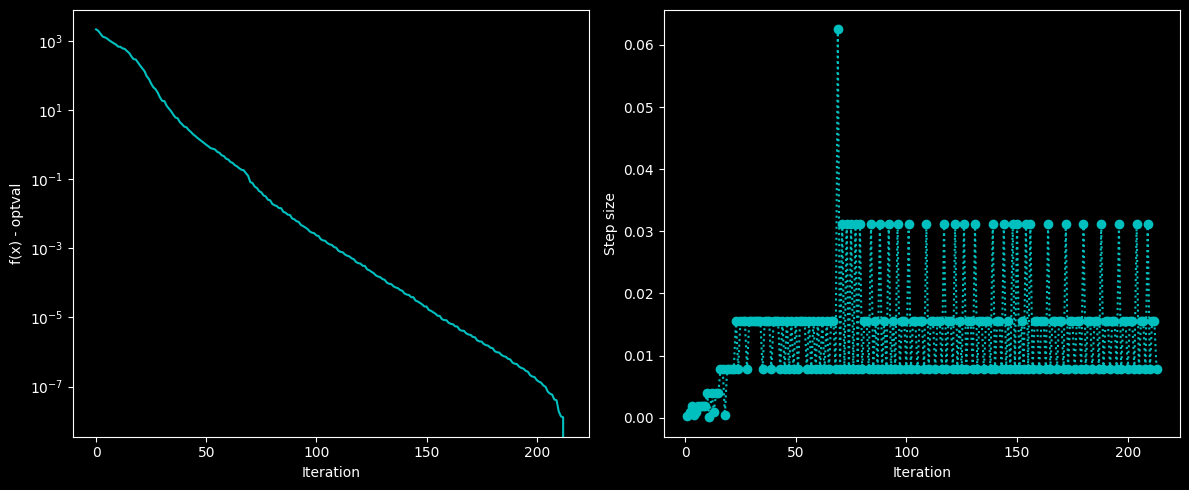

In [22]:
np.random.seed(42)

m = 1000  # num of constraints
n = 1000  # dim of x
alpha = 0.01
beta = 0.5
n_iters = 1000
grad_tol = 1e-3

A = np.random.randn(m, n)

vals = []  # function values
steps = []  # step sizes
x = np.zeros(n)  # x_0

start = time.time()
for iter in range(n_iters):
    # f(x) in matrix notation
    val = -np.sum(np.log(1 - A @ x)) - np.sum(np.log(1 + x)) - np.sum(np.log(1 - x))
    vals.append(val)

    # gradient
    grad = A.T @ (1 / (1 - A @ x)) - 1 / (1 + x) + 1 / (1 - x)

    if np.linalg.norm(grad) < grad_tol:
        break

    d_x = -grad # gradient descent step

    # backtracking line search
    t = 1

    # make sure t won't take x out of domain
    while np.max(A @ (x + t * d_x)) >= 1 or np.max(np.abs(x + t * d_x)) >= 1:
        t *= beta

    # line search stop criterion
    while (-np.sum(np.log(1 - A @ (x + t * d_x))) - np.sum(np.log(1 - (x + t * d_x)**2)) >
           val + alpha * t * (grad @ d_x)):
        t *= beta

    x += t * d_x
    steps.append(t)

print(f'Time taken (gradient descent): {time.time() - start:.4f} seconds')

p_star = vals[-1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].semilogy(range(len(vals)), vals - p_star, 'c-')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('f(x) - optval')

ax[1].plot(range(1, len(steps) + 1), steps, 'c:o')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Step size')

plt.tight_layout()
plt.show()

##### Newton's method

Recall

* compute Newton `step` and Newton `decrement`
$$\Delta x_{nt}=-\left(\nabla^2f(x)\right)^{-1}\nabla f(x);\, \lambda(x)=\left(\Delta x_{nt}^T \nabla^2 f(x) \Delta x_{nt}\right)^{1/2}$$
* stopping criterion
$$\frac{1}{2}\lambda(x)^2 \leq \epsilon$$
* line search for `step size`, starting at $t=1$, backtrack $t\leftarrow \beta t$ until
$$\begin{align*}f(x+t\Delta x_{nt})&< f(x)-\alpha t \lambda(x)^2
\end{align*}$$
* update
$$x\leftarrow x+t\Delta x_{nt}$$

In [23]:
def cholesky_factorization(A):
    m = A.shape[0]
    l_mat = A.copy().astype(float)

    for k in range(m):
        if l_mat[k, k] <= 0:
            raise ValueError('Matrix is not positive definite')

        # Follow the first step, iteratively apply to a smaller and smaller K
        l_mat[k+1:, k+1:] -= np.outer(l_mat[k+1:, k], l_mat[k+1:, k]) / l_mat[k, k]
        l_mat[k:, k] /= np.sqrt(l_mat[k, k])

    return np.tril(l_mat)

def forward_substitution(L, b):
    m, n = L.shape
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(L[i, :i], x[:i])) / L[i, i]
    return x

def back_substitution(R, b):
    m, n = R.shape
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - np.dot(R[i, i + 1:], x[i + 1:])) / R[i, i]
    return x

Time taken (Newton's method): 27.4603 seconds


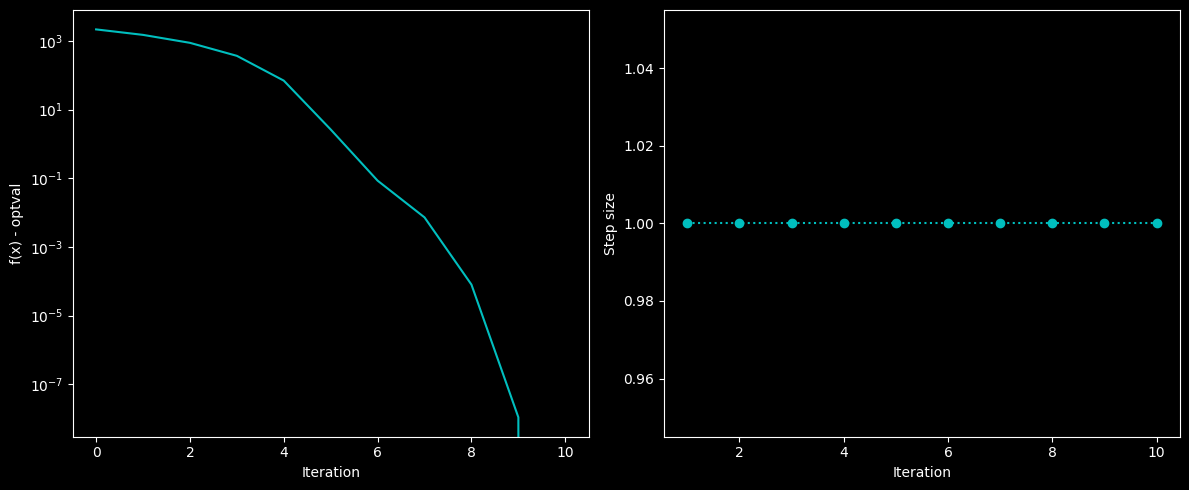

In [24]:
np.random.seed(42)

nt_tol = 1e-8

vals = []
steps = []
x = np.zeros(n)
np_solver = False
diag_only = False # we can approximate Hessian using its diagonal elements only

start = time.time()
for iter in range(n_iters):
    val = -np.sum(np.log(1 - A @ x)) - np.sum(np.log(1 + x)) - np.sum(np.log(1 - x))
    vals.append(val)

    d = 1 / (1 - A @ x)
    grad = A.T @ d - 1 / (1 + x) + 1 / (1 - x)

    # Hessian
    hess = (A.T @ (np.diag(d**2) @ A) +
            np.diag(1 / (1 + x)**2 + 1 / (1 - x)**2))

    if diag_only:
        hess = np.diag(np.diag(hess))

    # solve hess * d_x = -grad for newton step
    if np_solver:
        d_x = -np.linalg.solve(hess, grad)
    else:
        try:
            L = cholesky_factorization(hess)
            d_x = forward_substitution(L, -grad)
            d_x = back_substitution(L.T, d_x)
        except Exception as e:
            print(e)

    nt_decre_sq = -grad @ d_x  # newton decrement

    if abs(nt_decre_sq) < nt_tol:
        break

    # backtracking line search
    t = 1

    while np.max(A @ (x + t * d_x)) >= 1 or np.max(np.abs(x + t * d_x)) >= 1:
        t *= beta

    while (-np.sum(np.log(1 - A @ (x + t * d_x))) - np.sum(np.log(1 - (x + t * d_x)**2)) >
           val - alpha * t * nt_decre_sq):
        t *= beta

    x += t * d_x
    steps.append(t)

print(f'Time taken (Newton\'s method): {time.time() - start:.4f} seconds')

p_star = vals[-1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].semilogy(range(len(vals)), vals - p_star, 'c-')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('f(x) - optval')

ax[1].plot(range(1, len(steps) + 1), steps, 'c:o')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Step size')

plt.tight_layout()
plt.show()